## Attention Only Classification Analysis Scratch

In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import keras
from keras import backend as K
import tensorflow as tf

import os
import numpy as np
import pandas as pd
import scipy

import Bio
from Bio import SeqIO
import Bio.motifs

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection
import sklearn

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from signal_models_scratch import *
from utility_functions import *

sns.set_context('notebook')

Using TensorFlow backend.


In [2]:
working_directory = '/home/jtao/analysis/genomic_grammar_analysis/'

## Read Data

In [3]:
treatment_positive_fasta_dict = {}
treatment_negative_fasta_dict = {}
treatment_positive_seqArray_dict = {}
treatment_positive_rc_seqArray_dict = {}
treatment_negative_seqArray_dict = {}
treatment_negative_rc_seqArray_dict = {}

for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    treatment = ps.split('_')[1]
    print('***',treatment, '***')
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]
    
    positive_fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords]
    negative_fasta_seq = [str(x.seq[:200]) for x in negative_seqRecords]
    
    positive_rc_fasta_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords]
    negative_rc_fasta_seq = [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]
    
    positive_sequence_arrays = convert_sequences_to_array(positive_fasta_seq)
    positive_rc_sequence_arrays = convert_sequences_to_array(positive_rc_fasta_seq)
    
    negative_sequence_arrays = convert_sequences_to_array(negative_fasta_seq)
    negative_rc_sequence_arrays = convert_sequences_to_array(negative_rc_fasta_seq)
    
    treatment_positive_fasta_dict[treatment] = positive_fasta_seq
    treatment_negative_fasta_dict[treatment] = negative_fasta_seq
    treatment_positive_seqArray_dict[treatment] = positive_sequence_arrays
    treatment_positive_rc_seqArray_dict[treatment] = positive_rc_sequence_arrays
    treatment_negative_seqArray_dict[treatment] = negative_sequence_arrays
    treatment_negative_rc_seqArray_dict[treatment] = negative_rc_sequence_arrays

*** kla-1h ***
*** veh ***
*** il4-24h ***


## Set Model Settings

In [22]:
### settings for attention model ###
attention_num_motifs=96
attention_motif_size=14
adjacent_bp_pool_size=1
attention_num_dense_neurons = 8
attention_dropout_rate=0.1

### settings for convolution model ###
convolution_num_motifs=16
convolution_motif_size=24
num_dense_neurons=32
convolution_dropout_rate=0.5

largeConvolution_num_motifs = 49
large_num_dense_neurons = 98

In [23]:
dotProductAttention_model = get_dotProductAttention_model(200,
    mode='classification',
    num_motifs=attention_num_motifs, 
    motif_size=attention_motif_size,
    adjacent_bp_pool_size=adjacent_bp_pool_size,
    num_dense_neurons = attention_num_dense_neurons,
    dropout_rate=attention_dropout_rate,
    num_classes=2)
print('dotProductAttention_model', dotProductAttention_model.count_params())

convolution_model = get_convolution_model(200,
    mode='classification',
    num_motifs=convolution_num_motifs, 
    motif_size=convolution_motif_size,
    num_dense_neurons=num_dense_neurons,
    dropout_rate=convolution_dropout_rate,
    num_classes=2)
print('convolution_model', convolution_model.count_params())

large_convolution_model = get_convolution_model(200,
    mode='classification',
    num_motifs=largeConvolution_num_motifs, 
    motif_size=convolution_motif_size,
    num_dense_neurons=large_num_dense_neurons,
    dropout_rate=convolution_dropout_rate,
    num_classes=2)
print('large_convolution_model', large_convolution_model.count_params())



dotProductAttention_model 9738
convolution_model 2162
large_convolution_model 9851


## Train All Models for all Data Sets

In [24]:
condition_model_dict = {}

In [25]:
num_epochs = 20
num_iterations = 1
all_rocs = []
all_accuracies = []
all_precisions = []
all_treatments = []
model_types = []
parameter_counts = []
iteration_list = []

train_dotAttention = True
train_convolution = False
train_large_convolution = True
for iteration in range(1,num_iterations + 1):
    print('iteration', iteration)
    for treatment in sorted(treatment_positive_fasta_dict.keys()):
        positive_sequence_arrays = treatment_positive_seqArray_dict[treatment] 
        positive_rc_sequence_arrays = treatment_positive_rc_seqArray_dict[treatment]
        negative_sequence_arrays = treatment_negative_seqArray_dict[treatment]
        negative_rc_sequence_arrays = treatment_negative_rc_seqArray_dict[treatment]

        sequence_arrays = np.concatenate([positive_sequence_arrays, negative_sequence_arrays])
        sequence_rc_arrays = np.concatenate([positive_rc_sequence_arrays, negative_rc_sequence_arrays])
        labels = [1 for x in positive_sequence_arrays] + [0 for x in negative_sequence_arrays]
        labels = np.array(labels)

        x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(
            sequence_arrays, 
            sequence_rc_arrays, 
            labels, 
            test_size=0.2)

        num_classes = 2
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

        ### dot product attention model ###
        if train_dotAttention:
            print('Training DotAttention', treatment)
            dotProductAttention_model = get_dotProductAttention_model(200,
                mode='classification',
                num_motifs=attention_num_motifs, 
                motif_size=attention_motif_size,
                adjacent_bp_pool_size=adjacent_bp_pool_size,
                num_dense_neurons = attention_num_dense_neurons,  
                dropout_rate=attention_dropout_rate,
                num_classes=2)

            dotProductAttention_model.fit([x_train], y_train,
                      batch_size=64,
                      epochs=num_epochs,
                      verbose=1,
                      validation_data=([x_test], y_test))

            probs = dotProductAttention_model.predict([x_test])
            test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
            roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
            precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
            acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
            param_count = dotProductAttention_model.count_params()

            all_rocs.append(roc)
            all_accuracies.append(acc)
            all_precisions.append(precision)
            all_treatments.append(treatment)
            model_types.append('DotAttention')
            parameter_counts.append(param_count)
            iteration_list.append(iteration)
            condition_model_dict['DotAttention_'+treatment] = dotProductAttention_model
        ### ###

        ### large convolution model ###
        if train_large_convolution:
            print('Training Large Convolution', treatment)
            large_convolution_model = get_convolution_model(200,
                mode='classification',
                num_motifs=largeConvolution_num_motifs, 
                motif_size=convolution_motif_size,
                num_dense_neurons=large_num_dense_neurons,
                dropout_rate=convolution_dropout_rate,
                num_classes=2)
            large_convolution_model.fit([x_train, x_rc_train], y_train,
                      batch_size=64,
                      epochs=num_epochs,
                      verbose=1,
                      validation_data=([x_test, x_rc_test], y_test))

            probs = large_convolution_model.predict([x_test, x_rc_test])
            test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
            roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
            precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
            acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
            param_count = convolution_model.count_params()

            all_rocs.append(roc)
            all_accuracies.append(acc)
            all_precisions.append(precision)
            all_treatments.append(treatment)
            model_types.append('LargeConvolution')
            parameter_counts.append(param_count)
            iteration_list.append(iteration)
            condition_model_dict['LargeConvolution_'+treatment] = large_convolution_model

        ### convolution model ###
        if train_convolution:
            print('Training Convolution', treatment)
            convolution_model = get_convolution_model(200,
                mode='classification',
                num_motifs=convolution_num_motifs, 
                motif_size=convolution_motif_size,
                num_dense_neurons=num_dense_neurons,
                dropout_rate=convolution_dropout_rate,
                num_classes=2)
            convolution_model.fit([x_train, x_rc_train], y_train,
                      batch_size=64,
                      epochs=num_epochs,
                      verbose=1,
                      validation_data=([x_test, x_rc_test], y_test))

            probs = convolution_model.predict([x_test, x_rc_test])
            test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
            roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
            precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
            acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
            param_count = convolution_model.count_params()

            all_rocs.append(roc)
            all_accuracies.append(acc)
            all_precisions.append(precision)
            all_treatments.append(treatment)
            model_types.append('Convolution')
            parameter_counts.append(param_count)
            iteration_list.append(iteration)
            condition_model_dict['Convolution_'+treatment] = convolution_model

iteration 1
Training DotAttention il4-24h
Train on 53628 samples, validate on 13408 samples
Epoch 1/20
53628/53628 [==============================] - 51s 958us/step - loss: 0.6473 - categorical_accuracy: 0.6044 - val_loss: 0.5695 - val_categorical_accuracy: 0.7098
Epoch 2/20
53628/53628 [==============================] - 50s 928us/step - loss: 0.5588 - categorical_accuracy: 0.7133 - val_loss: 0.5207 - val_categorical_accuracy: 0.7452
Epoch 3/20
53628/53628 [==============================] - 50s 933us/step - loss: 0.5115 - categorical_accuracy: 0.7497 - val_loss: 0.5215 - val_categorical_accuracy: 0.7413
Epoch 4/20
53628/53628 [==============================] - 50s 928us/step - loss: 0.4741 - categorical_accuracy: 0.7728 - val_loss: 0.4450 - val_categorical_accuracy: 0.7982
Epoch 5/20
53628/53628 [==============================] - 50s 927us/step - loss: 0.4293 - categorical_accuracy: 0.8015 - val_loss: 0.4145 - val_categorical_accuracy: 0.8154
Epoch 6/20
53628/53628 [===================

Epoch 7/20
34841/34841 [==============================] - 33s 941us/step - loss: 0.3875 - categorical_accuracy: 0.8247 - val_loss: 0.3928 - val_categorical_accuracy: 0.8237
Epoch 8/20
34841/34841 [==============================] - 33s 949us/step - loss: 0.3648 - categorical_accuracy: 0.8376 - val_loss: 0.4330 - val_categorical_accuracy: 0.7989
Epoch 9/20
34841/34841 [==============================] - 33s 944us/step - loss: 0.3507 - categorical_accuracy: 0.8449 - val_loss: 0.3714 - val_categorical_accuracy: 0.8335
Epoch 10/20
34841/34841 [==============================] - 33s 940us/step - loss: 0.3390 - categorical_accuracy: 0.8524 - val_loss: 0.4191 - val_categorical_accuracy: 0.8110
Epoch 11/20
34841/34841 [==============================] - 33s 947us/step - loss: 0.3279 - categorical_accuracy: 0.8574 - val_loss: 0.3525 - val_categorical_accuracy: 0.8409
Epoch 12/20
34841/34841 [==============================] - 33s 945us/step - loss: 0.3163 - categorical_accuracy: 0.8641 - val_loss: 0

50480/50480 [==============================] - 47s 934us/step - loss: 0.3068 - categorical_accuracy: 0.8698 - val_loss: 0.3335 - val_categorical_accuracy: 0.8552
Epoch 14/20
50480/50480 [==============================] - 47s 929us/step - loss: 0.3035 - categorical_accuracy: 0.8717 - val_loss: 0.3574 - val_categorical_accuracy: 0.8471
Epoch 15/20
50480/50480 [==============================] - 47s 932us/step - loss: 0.2977 - categorical_accuracy: 0.8743 - val_loss: 0.3318 - val_categorical_accuracy: 0.8574
Epoch 16/20
50480/50480 [==============================] - 47s 934us/step - loss: 0.2943 - categorical_accuracy: 0.8755 - val_loss: 0.3315 - val_categorical_accuracy: 0.8579
Epoch 17/20
50480/50480 [==============================] - 47s 931us/step - loss: 0.2878 - categorical_accuracy: 0.8795 - val_loss: 0.3365 - val_categorical_accuracy: 0.8583
Epoch 18/20
50480/50480 [==============================] - 47s 931us/step - loss: 0.2849 - categorical_accuracy: 0.8805 - val_loss: 0.3591 - v

In [26]:
performance_frame = pd.DataFrame({'Model Type': model_types, 
                                  'Treatment':all_treatments,
                                  'Accuracy':all_accuracies, 
                                  'aucROC':all_rocs,
                                  'Precision':all_precisions})

In [27]:
performance_frame

,Accuracy,Model Type,Precision,Treatment,aucROC
0,0.860233,DotAttention,0.814514,il4-24h,0.926833
1,0.846137,LargeConvolution,0.835491,il4-24h,0.925178
2,0.865687,DotAttention,0.862601,kla-1h,0.920483
3,0.834807,LargeConvolution,0.807774,kla-1h,0.903245
4,0.862995,DotAttention,0.866582,veh,0.930970
5,0.844849,LargeConvolution,0.860847,veh,0.921088


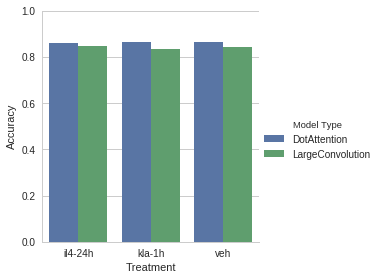

In [28]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'Accuracy',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

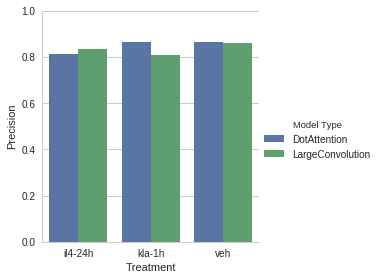

In [29]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'Precision',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

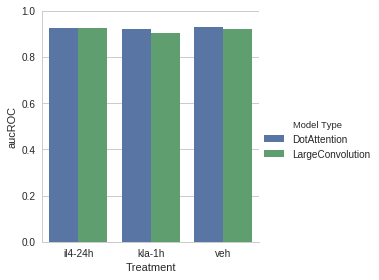

In [30]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'aucROC',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

## Grid Search